In [188]:
import tkinter as tk
from tkinter import filedialog
import os

# Define the starting folder path
start_path = r"C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\SEM"
#start_path = r'D:\Particle tracking'

root = tk.Tk()
root.withdraw()  # Hide the main window

# Bring the dialog to the front
root.lift()
root.attributes('-topmost', True)

try:
    # Allow the user to select a TIF file starting from the specified start path
    tif_file_path = filedialog.askopenfilename(
        initialdir=start_path,
        title="Select a TIF file",
        filetypes=[("TIF files", "*.tif"), ("All files", "*.*")]
    )
    
    # Check if a file was selected (user didn't cancel)
    if tif_file_path:
        # Convert to absolute path (though askopenfilename usually returns absolute path)
        tif_file_path = os.path.abspath(tif_file_path)
        print(f"Selected TIF file path: {tif_file_path}")
    else:
        print("File selection canceled by the user.")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

File selection canceled by the user.


In [179]:
import cv2
import numpy as np

# Load the TIF file
image = cv2.imread(tif_file_path, cv2.IMREAD_UNCHANGED)

# Convert 16-bit to 8-bit for display (if needed)
if image.dtype == np.uint16:
    lower = np.percentile(image, 1)
    upper = np.percentile(image, 99)
    image_8bit = np.clip((image - lower) / (upper - lower) * 255, 0, 255).astype(np.uint8)
else:
    image_8bit = image.copy()

# Create window
window_name = "Select ROI - Press 'q' to quit"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Window settings
window_width = 1200
window_height = 800

# Manual screen size (adjust these to your actual screen resolution)
screen_width = 1920  # Change this to your screen width
screen_height = 1080  # Change this to your screen height

# Calculate center position with manual offset if needed
pos_x = (screen_width - window_width) // 2
pos_y = (screen_height - window_height) // 2

# Add manual offset to shift right (adjust this value)
pos_x += 100  # Shift 100 pixels to the right

# Resize and position the window
cv2.resizeWindow(window_name, window_width, window_height)
cv2.moveWindow(window_name, pos_x, pos_y)

# Variables for rectangle drawing
drawing = False
start_x, start_y = -1, -1
end_x, end_y = -1, -1
roi_selected = False

def draw_rectangle(event, x, y, flags, param):
    global drawing, start_x, start_y, end_x, end_y, image_8bit, roi_selected
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_x, start_y = x, y
        end_x, end_y = x, y
        roi_selected = False
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            end_x, end_y = x, y
            
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_x, end_y = x, y
        roi_selected = True

cv2.setMouseCallback(window_name, draw_rectangle)

print("Draw a rectangle by clicking and dragging. Press 'q' to quit, SPACE/ENTER to confirm")

while True:
    # Display image
    display_img = image_8bit.copy()
    
    # Draw rectangle if coordinates are set
    if start_x != -1 and end_x != -1:
        # Draw a simple rectangle without handles
        cv2.rectangle(display_img, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    
    cv2.imshow(window_name, display_img)
    
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):  # Quit
        print("Selection cancelled")
        cv2.destroyAllWindows()
        roi = None
        roi_coords = None
        break
        
    elif key == 13 or key == 32:  # Enter or Space
        if roi_selected and start_x != -1:
            # Calculate ROI coordinates
            x1 = min(start_x, end_x)
            y1 = min(start_y, end_y)
            x2 = max(start_x, end_x)
            y2 = max(start_y, end_y)
            
            # Extract ROI from original image
            roi = image[y1:y2, x1:x2]
            roi_coords = (x1, y1, x2-x1, y2-y1)  # x, y, width, height
            
            print(f"ROI selected: x={x1}, y={y1}, width={x2-x1}, height={y2-y1}")
            cv2.destroyAllWindows()
            break

Draw a rectangle by clicking and dragging. Press 'q' to quit, SPACE/ENTER to confirm
ROI selected: x=0, y=3, width=2591, height=1780


In [180]:
# import porespy as ps
# import numpy as np
# from skimage import filters, morphology, measure
# import matplotlib.pyplot as plt
# import cv2

# # Convert to grayscale if needed
# if len(roi.shape) == 3:
#     roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
# else:
#     roi_gray = roi

# # Try different thresholding methods
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# # Original
# axes[0,0].imshow(roi_gray, cmap='gray')
# axes[0,0].set_title('Original ROI')

# # Method 1: Otsu (what you had)
# thresh_otsu = filters.threshold_otsu(roi_gray)
# binary_otsu = roi_gray < thresh_otsu
# axes[0,1].imshow(binary_otsu, cmap='gray')
# axes[0,1].set_title(f'Otsu (thresh={thresh_otsu:.0f})')

# # Method 2: Manual threshold - try to capture only the darkest regions
# thresh_manual = np.percentile(roi_gray, 30)  # Adjust this percentile
# binary_manual = roi_gray < thresh_manual
# axes[0,2].imshow(binary_manual, cmap='gray')
# axes[0,2].set_title(f'Manual (thresh={thresh_manual:.0f})')

# # Method 3: Adaptive threshold
# binary_adaptive = cv2.adaptiveThreshold(roi_gray, 255, 
#                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                       cv2.THRESH_BINARY_INV, 21, 5)
# binary_adaptive = binary_adaptive > 0
# axes[1,0].imshow(binary_adaptive, cmap='gray')
# axes[1,0].set_title('Adaptive Threshold')

# # Method 4: Multi-level Otsu
# thresholds = filters.threshold_multiotsu(roi_gray, classes=3)
# binary_multi = roi_gray < thresholds[0]  # Use lowest threshold
# axes[1,1].imshow(binary_multi, cmap='gray')
# axes[1,1].set_title(f'Multi-Otsu (thresh={thresholds[0]:.0f})')

# # Method 5: Li's method (often good for uneven illumination)
# thresh_li = filters.threshold_li(roi_gray)
# binary_li = roi_gray < thresh_li
# axes[1,2].imshow(binary_li, cmap='gray')
# axes[1,2].set_title(f'Li method (thresh={thresh_li:.0f})')

# plt.tight_layout()
# plt.show()

# # Let user choose which method to use
# print("Which thresholding method looks best? (1-5)")
# print("You want BLACK regions to be the pores (holes)")

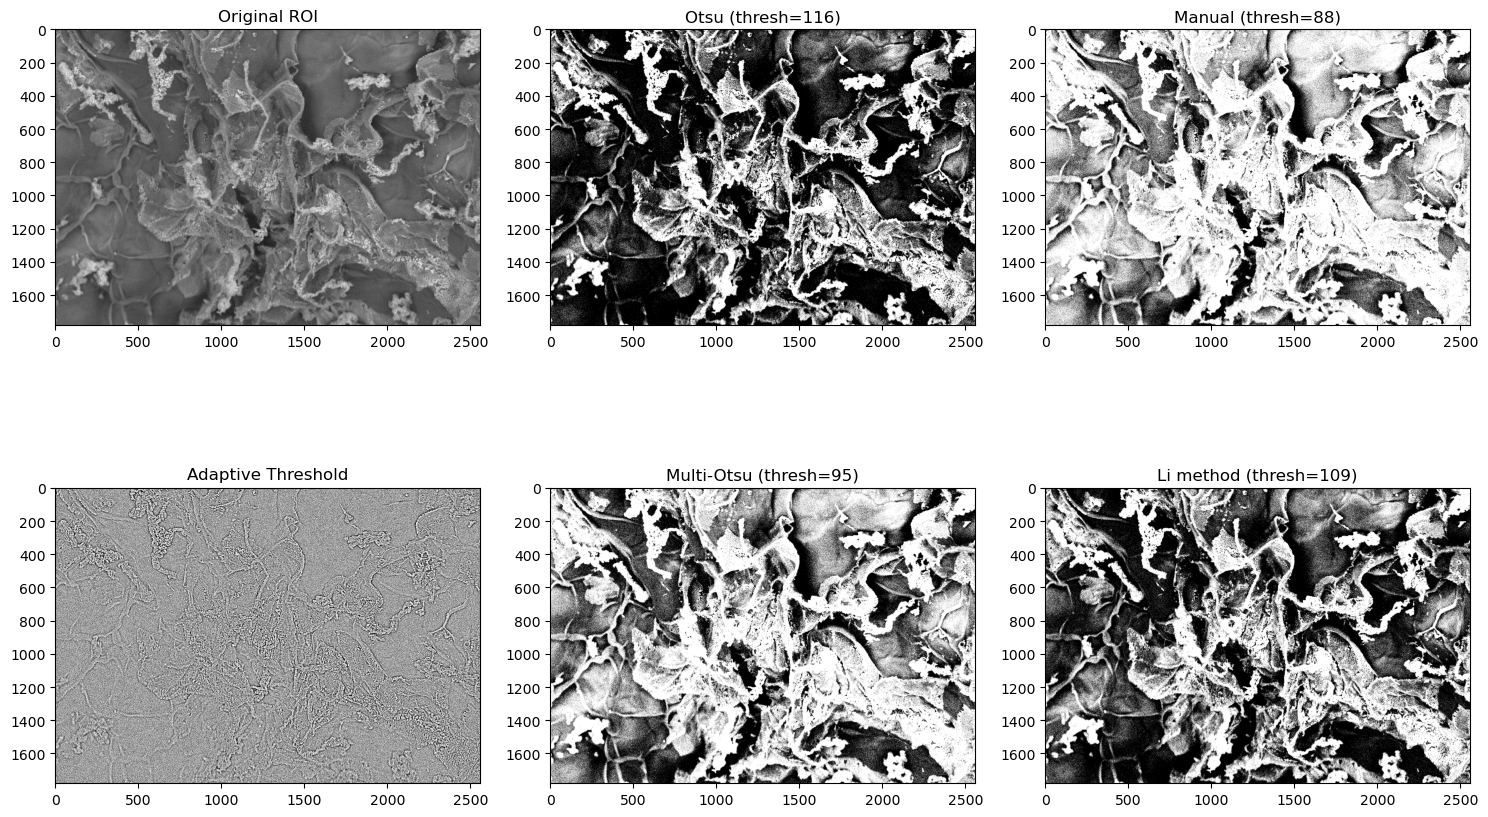

Which thresholding method looks best? (1-5)
Pores are shown as BLACK regions (matching the original image)


Now use the slider below to manually adjust the threshold:


IntSlider(value=116, continuous_update=False, description='Threshold:', layout=Layout(width='80%'), max=255, s…

Output()


Quick threshold selection:


In [181]:
import porespy as ps
import numpy as np
from skimage import filters, morphology, measure
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from IPython.display import display

# Convert to grayscale if needed
if len(roi.shape) == 3:
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
else:
    roi_gray = roi

# First show all the automatic methods as before
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original
axes[0,0].imshow(roi_gray, cmap='gray')
axes[0,0].set_title('Original ROI')

# Method 1: Otsu
thresh_otsu = filters.threshold_otsu(roi_gray)
binary_otsu = roi_gray < thresh_otsu
axes[0,1].imshow(~binary_otsu, cmap='gray')  # Invert to show pores as black
axes[0,1].set_title(f'Otsu (thresh={thresh_otsu:.0f})')

# Method 2: Manual threshold - try to capture only the darkest regions
thresh_manual = np.percentile(roi_gray, 30)
binary_manual = roi_gray < thresh_manual
axes[0,2].imshow(~binary_manual, cmap='gray')  # Invert to show pores as black
axes[0,2].set_title(f'Manual (thresh={thresh_manual:.0f})')

# Method 3: Adaptive threshold
binary_adaptive = cv2.adaptiveThreshold(roi_gray, 255, 
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 21, 5)
binary_adaptive = binary_adaptive > 0
axes[1,0].imshow(~binary_adaptive, cmap='gray')  # Invert to show pores as black
axes[1,0].set_title('Adaptive Threshold')

# Method 4: Multi-level Otsu
thresholds = filters.threshold_multiotsu(roi_gray, classes=3)
binary_multi = roi_gray < thresholds[0]
axes[1,1].imshow(~binary_multi, cmap='gray')  # Invert to show pores as black
axes[1,1].set_title(f'Multi-Otsu (thresh={thresholds[0]:.0f})')

# Method 5: Li's method
thresh_li = filters.threshold_li(roi_gray)
binary_li = roi_gray < thresh_li
axes[1,2].imshow(~binary_li, cmap='gray')  # Invert to show pores as black
axes[1,2].set_title(f'Li method (thresh={thresh_li:.0f})')

plt.tight_layout()
plt.show()

print("Which thresholding method looks best? (1-5)")
print("Pores are shown as BLACK regions (matching the original image)")
print("\n" + "="*50 + "\n")
print("Now use the slider below to manually adjust the threshold:")

# Interactive threshold adjustment
def update_threshold(threshold_value):
    """Update the binary image based on the threshold slider value"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Show original
    ax1.imshow(roi_gray, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Apply threshold
    binary_image = roi_gray < threshold_value
    
    # Show binary result (inverted to show pores as black)
    ax2.imshow(~binary_image, cmap='gray')  # Invert to show pores as black
    ax2.set_title(f'Binary (Threshold = {threshold_value}) - Pores in Black')
    ax2.axis('off')
    
    # Show overlay
    overlay = np.zeros((*roi_gray.shape, 3))
    overlay[..., 0] = roi_gray / 255.0  # Red channel for original
    overlay[..., 1] = roi_gray / 255.0  # Green channel for original
    overlay[..., 2] = roi_gray / 255.0  # Blue channel for original
    overlay[binary_image, 0] = 1  # Highlight detected pores in red
    overlay[binary_image, 1] = 0
    overlay[binary_image, 2] = 0
    
    ax3.imshow(overlay)
    ax3.set_title('Overlay (Pores in Red)')
    ax3.axis('off')
    
    # Calculate and display statistics
    num_pores = np.sum(binary_image)
    pore_percentage = (num_pores / binary_image.size) * 100
    
    # Count individual pores
    labeled_pores = measure.label(binary_image)
    num_individual_pores = np.max(labeled_pores)
    
    plt.suptitle(f'Pore pixels: {num_pores:,} ({pore_percentage:.1f}%) | Individual pores: {num_individual_pores}')
    plt.tight_layout()
    plt.show()

# Create slider widget
threshold_slider = widgets.IntSlider(
    value=thresh_otsu,  # Start with Otsu threshold
    min=roi_gray.min(),
    max=roi_gray.max(),
    step=1,
    description='Threshold:',
    continuous_update=False,  # Only update when slider is released
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='80%')
)

# Create interactive output
interactive_output = widgets.interactive_output(update_threshold, {'threshold_value': threshold_slider})

# Display the slider and output
display(threshold_slider, interactive_output)

# Add buttons for quick selection of different threshold methods
def set_otsu(b):
    threshold_slider.value = int(thresh_otsu)

def set_li(b):
    threshold_slider.value = int(thresh_li)

def set_multiotsu(b):
    threshold_slider.value = int(thresholds[0])

def set_percentile_20(b):
    threshold_slider.value = int(np.percentile(roi_gray, 20))

def set_percentile_30(b):
    threshold_slider.value = int(np.percentile(roi_gray, 30))

# Create buttons
button_otsu = widgets.Button(description="Otsu")
button_li = widgets.Button(description="Li")
button_multiotsu = widgets.Button(description="Multi-Otsu")
button_p20 = widgets.Button(description="20th Percentile")
button_p30 = widgets.Button(description="30th Percentile")

# Connect buttons to functions
button_otsu.on_click(set_otsu)
button_li.on_click(set_li)
button_multiotsu.on_click(set_multiotsu)
button_p20.on_click(set_percentile_20)
button_p30.on_click(set_percentile_30)

# Display buttons
print("\nQuick threshold selection:")
display(widgets.HBox([button_otsu, button_li, button_multiotsu, button_p20, button_p30]))

In [182]:
# import numpy as np
# from skimage import filters
# import matplotlib.pyplot as plt

# # Get the multi-Otsu thresholds
# thresholds = filters.threshold_multiotsu(roi_gray, classes=3)
# print(f"Multi-Otsu thresholds: {thresholds}")
# print(f"This divides the image into 3 classes:")
# print(f"  Class 1: 0 to {thresholds[0]:.0f} (darkest - likely pores)")
# print(f"  Class 2: {thresholds[0]:.0f} to {thresholds[1]:.0f} (medium gray)")
# print(f"  Class 3: {thresholds[1]:.0f} to 255 (brightest)")

# # Visualize the histogram and thresholds
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# # Histogram with thresholds
# ax = axes[0, 0]
# hist, bins = np.histogram(roi_gray.flatten(), bins=256, range=[0, 256])
# ax.plot(bins[:-1], hist, 'k-', alpha=0.7)
# ax.axvline(thresholds[0], color='red', linestyle='--', label=f'Thresh 1: {thresholds[0]:.0f}')
# ax.axvline(thresholds[1], color='blue', linestyle='--', label=f'Thresh 2: {thresholds[1]:.0f}')
# ax.set_xlabel('Pixel Intensity')
# ax.set_ylabel('Count')
# ax.set_title('Histogram with Multi-Otsu Thresholds')
# ax.legend()
# ax.set_yscale('log')  # Log scale to see better

# # Show what each threshold captures
# axes[0, 1].imshow(roi_gray, cmap='gray')
# axes[0, 1].set_title('Original')

# axes[1, 0].imshow(roi_gray < thresholds[0], cmap='gray')
# axes[1, 0].set_title(f'Using first threshold (<{thresholds[0]:.0f})')

# axes[1, 1].imshow(roi_gray < thresholds[1], cmap='gray')
# axes[1, 1].set_title(f'Using second threshold (<{thresholds[1]:.0f})')

# plt.tight_layout()
# plt.show()

# # Try different number of classes
# print("\nTrying different number of classes:")
# for n_classes in range(2, 6):
#     thresh = filters.threshold_multiotsu(roi_gray, classes=n_classes)
#     print(f"{n_classes} classes: thresholds = {thresh}")

In [183]:
import re
import tifffile

# Function to extract scale from TM4000 metadata
def extract_tm4000_scale(tif_file_path):
    with tifffile.TiffFile(tif_file_path) as tif:
        page = tif.pages[0]
        
        # Get XPComment which contains the metadata
        if 'XPComment' in page.tags:
            comment = page.tags['XPComment'].value
            # Convert bytes to string
            if isinstance(comment, bytes):
                # Remove null bytes and decode
                comment_str = comment.decode('utf-16-le', errors='ignore')
            else:
                comment_str = str(comment)
            
            # Extract PixelSize
            pixel_size_match = re.search(r'PixelSize=([0-9.]+)', comment_str)
            if pixel_size_match:
                pixel_size_nm = float(pixel_size_match.group(1))
                pixel_size_um = pixel_size_nm / 1000  # Convert nm to μm
                
                print(f"Found TM4000 metadata:")
                print(f"  PixelSize: {pixel_size_nm} nm/pixel")
                print(f"  PixelSize: {pixel_size_um:.6f} μm/pixel")
                
                # Also extract other useful info
                mag_match = re.search(r'Mag=x([0-9.]+)k', comment_str)
                if mag_match:
                    magnification = float(mag_match.group(1)) * 1000
                    print(f"  Magnification: {magnification}x")
                
                return pixel_size_um
            else:
                print("PixelSize not found in metadata")
                return None
    
    return None

# Extract scale automatically
um_per_pixel = extract_tm4000_scale(tif_file_path)

if um_per_pixel:
    print(f"\nScale successfully extracted: {um_per_pixel:.6f} μm/pixel")
else:
    print("\nManual scale input needed")
    # Fall back to manual measurement
    scale_bar_length_pixels = float(input("Enter scale bar length in pixels: "))
    scale_bar_length_um = 100  # From your image
    um_per_pixel = scale_bar_length_um / scale_bar_length_pixels
    print(f"Manual scale: {um_per_pixel:.6f} μm/pixel")

Found TM4000 metadata:
  PixelSize: 62.01172 nm/pixel
  PixelSize: 0.062012 μm/pixel

Scale successfully extracted: 0.062012 μm/pixel


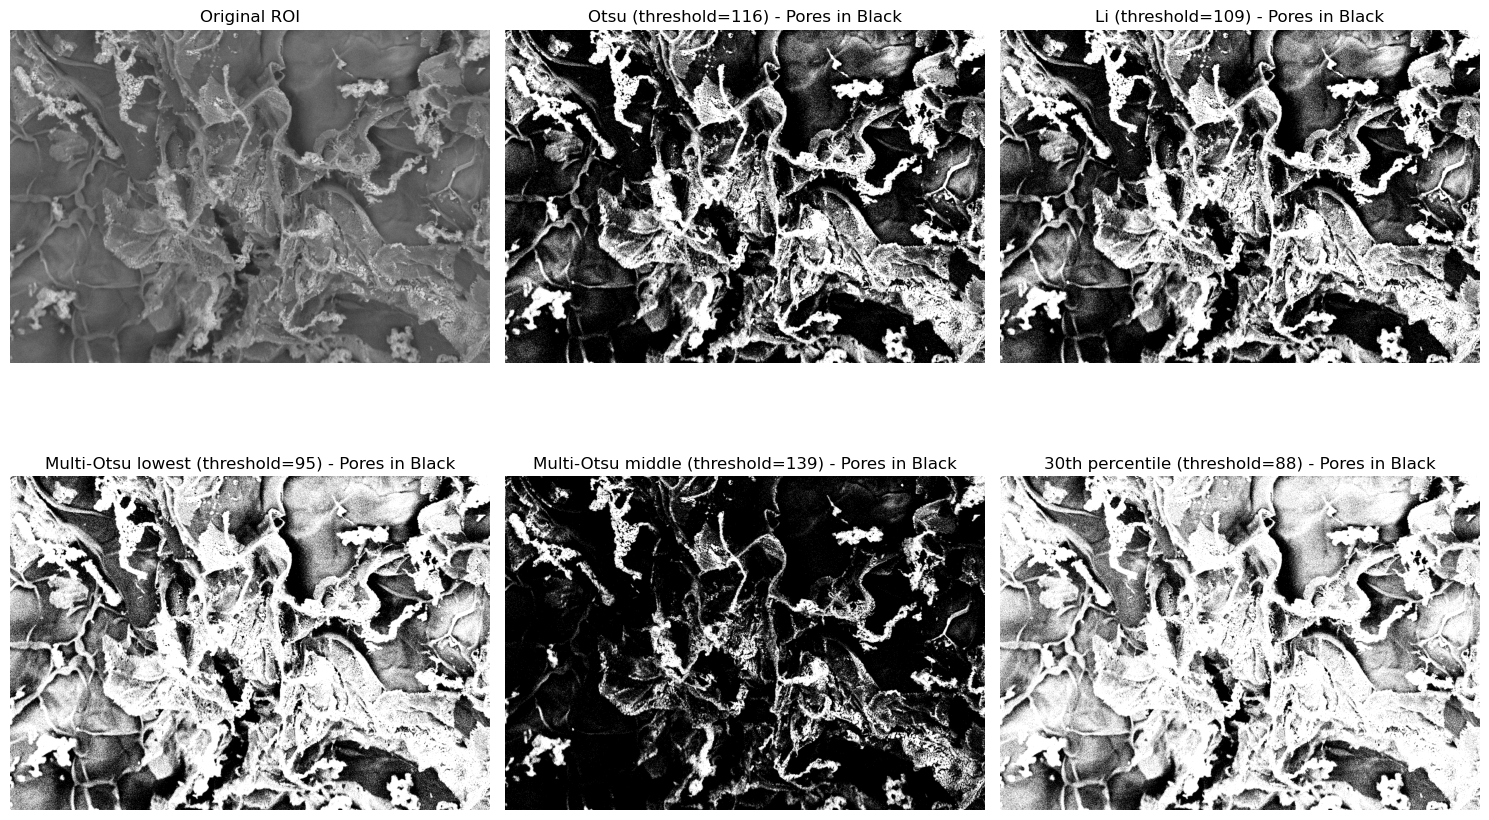


Threshold Options:
1. Otsu: 116
2. Li: 109
3. Multi-Otsu (lowest): 95
4. Multi-Otsu (middle): 139
5. 30th percentile: 88
6. Enter custom value



Select threshold method (1-6):  3



Using Multi-Otsu (lowest) threshold: 95


0it [00:00, ?it/s]

Using SNOW partitioning for segmentation


  0%|          | 0/25 [00:00<?, ?it/s]


PORE ANALYSIS RESULTS (using PoreSpy with Multi-Otsu (lowest))

Number of pores detected: 1630

Pore Diameter Statistics (μm):
  Mean diameter:   1.71 μm
  Median diameter: 1.50 μm
  Std deviation:   1.04 μm
  Min diameter:    0.48 μm
  Max diameter:    7.29 μm

Porosity: 29.2%


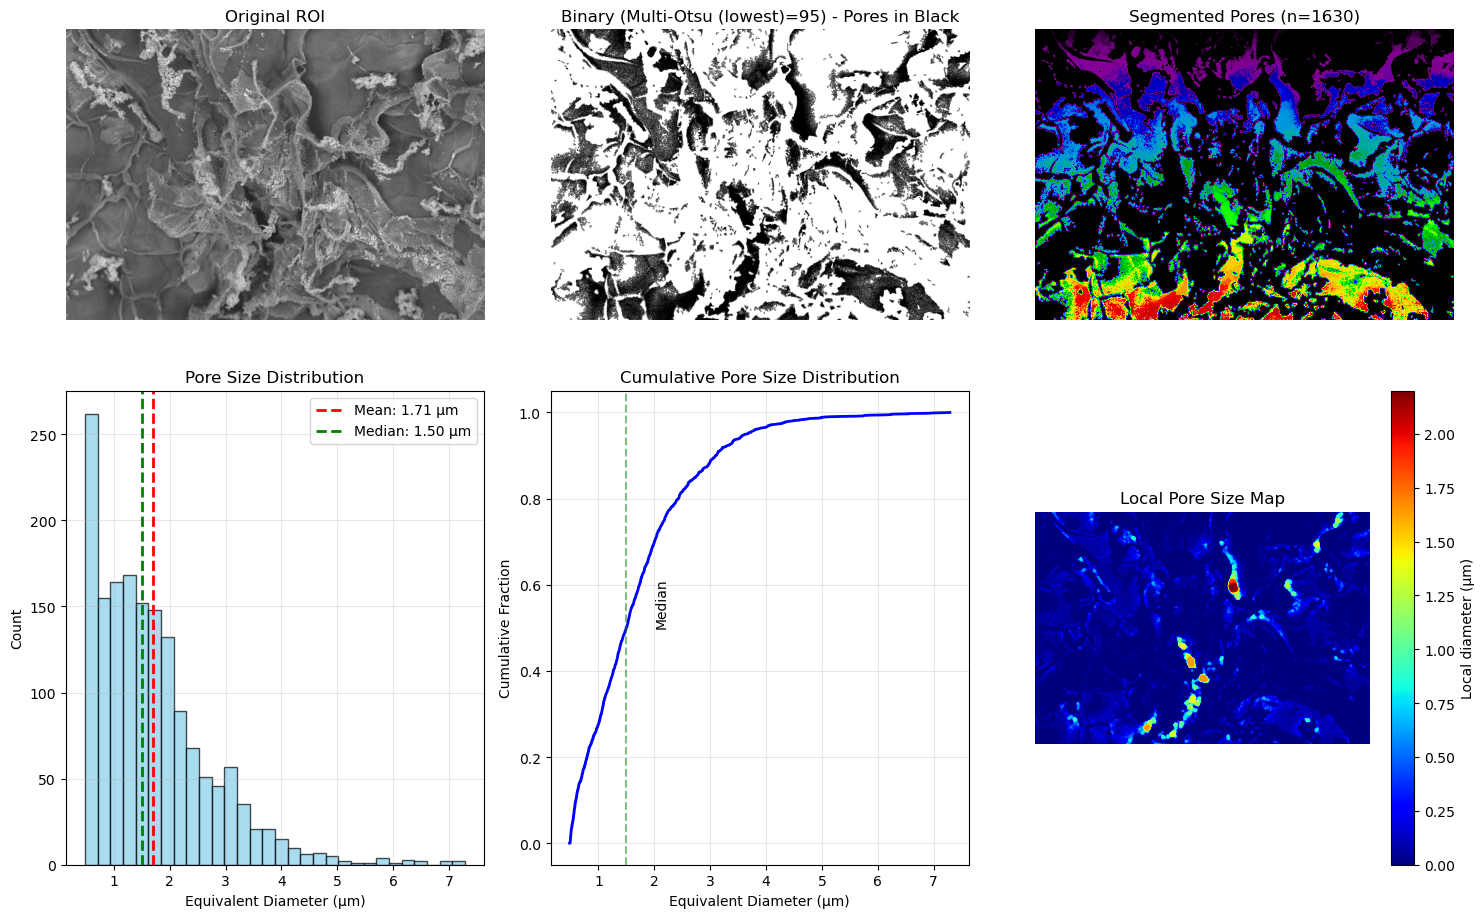

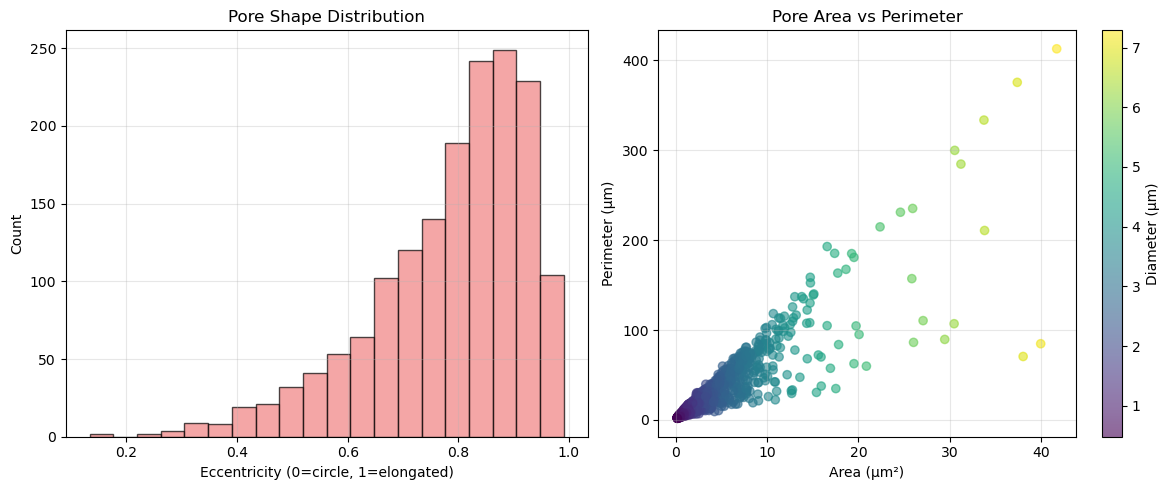


Pore Diameter Percentiles (μm):
  10th percentile: 0.60 μm
  25th percentile: 0.92 μm
  50th percentile: 1.50 μm
  75th percentile: 2.18 μm
  90th percentile: 3.10 μm

Pore Shape Statistics:
  Mean eccentricity: 0.786
  Mean solidity: 0.626


In [184]:
import porespy as ps
import numpy as np
from skimage import filters, morphology, measure
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd

# Use the scale we extracted
#um_per_pixel = 0.04960938  # From TM4000 metadata

# Calculate different threshold options
thresh_otsu = filters.threshold_otsu(roi_gray)
thresh_li = filters.threshold_li(roi_gray)
thresholds_multiotsu = filters.threshold_multiotsu(roi_gray, classes=3)

# Show preview of different thresholds
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(roi_gray, cmap='gray')
axes[0,0].set_title('Original ROI')
axes[0,0].axis('off')

axes[0,1].imshow(~(roi_gray < thresh_otsu), cmap='gray')
axes[0,1].set_title(f'Otsu (threshold={thresh_otsu:.0f}) - Pores in Black')
axes[0,1].axis('off')

axes[0,2].imshow(~(roi_gray < thresh_li), cmap='gray')
axes[0,2].set_title(f'Li (threshold={thresh_li:.0f}) - Pores in Black')
axes[0,2].axis('off')

axes[1,0].imshow(~(roi_gray < thresholds_multiotsu[0]), cmap='gray')
axes[1,0].set_title(f'Multi-Otsu lowest (threshold={thresholds_multiotsu[0]:.0f}) - Pores in Black')
axes[1,0].axis('off')

axes[1,1].imshow(~(roi_gray < thresholds_multiotsu[1]), cmap='gray')
axes[1,1].set_title(f'Multi-Otsu middle (threshold={thresholds_multiotsu[1]:.0f}) - Pores in Black')
axes[1,1].axis('off')

# Manual threshold example
manual_thresh = np.percentile(roi_gray, 30)
axes[1,2].imshow(~(roi_gray < manual_thresh), cmap='gray')
axes[1,2].set_title(f'30th percentile (threshold={manual_thresh:.0f}) - Pores in Black')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# Ask user to choose threshold
print("\nThreshold Options:")
print(f"1. Otsu: {thresh_otsu:.0f}")
print(f"2. Li: {thresh_li:.0f}")
print(f"3. Multi-Otsu (lowest): {thresholds_multiotsu[0]:.0f}")
print(f"4. Multi-Otsu (middle): {thresholds_multiotsu[1]:.0f}")
print(f"5. 30th percentile: {manual_thresh:.0f}")
print("6. Enter custom value")

# Get user input
choice = input("\nSelect threshold method (1-6): ")

if choice == '1':
    threshold = thresh_otsu
    method_name = "Otsu"
elif choice == '2':
    threshold = thresh_li
    method_name = "Li"
elif choice == '3':
    threshold = thresholds_multiotsu[0]
    method_name = "Multi-Otsu (lowest)"
elif choice == '4':
    threshold = thresholds_multiotsu[1]
    method_name = "Multi-Otsu (middle)"
elif choice == '5':
    threshold = manual_thresh
    method_name = "30th percentile"
elif choice == '6':
    threshold = float(input("Enter custom threshold value: "))
    method_name = f"Custom ({threshold:.0f})"
else:
    print("Invalid choice, using Multi-Otsu (lowest)")
    threshold = thresholds_multiotsu[0]
    method_name = "Multi-Otsu (lowest)"

print(f"\nUsing {method_name} threshold: {threshold:.0f}")

# Create binary image (pores are dark, below threshold)
# Note: binary=True for pores, but we invert display to show pores as black
binary = roi_gray < threshold

# Clean up the binary image first
binary_cleaned = morphology.remove_small_objects(binary, min_size=50)

# Method 1: Use PoreSpy's snow algorithm (best for separating touching pores)
try:
    snow = ps.filters.snow_partitioning(binary_cleaned, sigma=1.5, r_max=10)
    regions = snow.regions
    print("Using SNOW partitioning for segmentation")
except:
    # Fallback: Use standard watershed
    dt = ndimage.distance_transform_edt(binary_cleaned)
    peaks = ps.filters.find_peaks(dt=dt, r_max=10)
    regions = ps.filters.watershed(image=dt, markers=peaks, mask=binary_cleaned)
    print("Using watershed segmentation")

# Get region properties
# First label the regions properly
labeled = measure.label(regions)
props = measure.regionprops(labeled)

# Create DataFrame with pore measurements
pore_data = []
for prop in props:
    area_pixels = prop.area
    area_um2 = area_pixels * (um_per_pixel ** 2)
    equivalent_diameter_um = prop.equivalent_diameter * um_per_pixel
    
    pore_data.append({
        'area_pixels': area_pixels,
        'area_um2': area_um2,
        'equivalent_diameter_um': equivalent_diameter_um,
        'perimeter_um': prop.perimeter * um_per_pixel,
        'eccentricity': prop.eccentricity,
        'major_axis_um': prop.major_axis_length * um_per_pixel,
        'minor_axis_um': prop.minor_axis_length * um_per_pixel,
        'solidity': prop.solidity
    })

df = pd.DataFrame(pore_data)

# Calculate key statistics
mean_diameter = df['equivalent_diameter_um'].mean()
median_diameter = df['equivalent_diameter_um'].median()
std_diameter = df['equivalent_diameter_um'].std()

# Calculate porosity using PoreSpy
porosity = ps.metrics.porosity(binary_cleaned)

# Get local thickness (pore size map)
local_thickness = ps.filters.local_thickness(binary_cleaned)

# Print results
print("\n" + "="*50)
print(f"PORE ANALYSIS RESULTS (using PoreSpy with {method_name})")
print("="*50)
print(f"\nNumber of pores detected: {len(df)}")
print(f"\nPore Diameter Statistics (μm):")
print(f"  Mean diameter:   {mean_diameter:.2f} μm")
print(f"  Median diameter: {median_diameter:.2f} μm")
print(f"  Std deviation:   {std_diameter:.2f} μm")
print(f"  Min diameter:    {df['equivalent_diameter_um'].min():.2f} μm")
print(f"  Max diameter:    {df['equivalent_diameter_um'].max():.2f} μm")

print(f"\nPorosity: {porosity*100:.1f}%")

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original
axes[0,0].imshow(roi_gray, cmap='gray')
axes[0,0].set_title('Original ROI')
axes[0,0].axis('off')

# Binary - inverted to show pores as black (matching original)
axes[0,1].imshow(~binary_cleaned, cmap='gray')
axes[0,1].set_title(f'Binary ({method_name}={threshold:.0f}) - Pores in Black')
axes[0,1].axis('off')

# Segmented regions
axes[0,2].imshow(labeled, cmap='nipy_spectral')
axes[0,2].set_title(f'Segmented Pores (n={len(df)})')
axes[0,2].axis('off')

# Pore size distribution histogram
axes[1,0].hist(df['equivalent_diameter_um'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1,0].axvline(mean_diameter, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_diameter:.2f} μm')
axes[1,0].axvline(median_diameter, color='green', linestyle='--', linewidth=2, label=f'Median: {median_diameter:.2f} μm')
axes[1,0].set_xlabel('Equivalent Diameter (μm)')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Pore Size Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_diameters = np.sort(df['equivalent_diameter_um'])
cumulative = np.arange(1, len(sorted_diameters) + 1) / len(sorted_diameters)
axes[1,1].plot(sorted_diameters, cumulative, 'b-', linewidth=2)
axes[1,1].set_xlabel('Equivalent Diameter (μm)')
axes[1,1].set_ylabel('Cumulative Fraction')
axes[1,1].set_title('Cumulative Pore Size Distribution')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axvline(median_diameter, color='green', linestyle='--', alpha=0.5)
axes[1,1].text(median_diameter+0.5, 0.5, 'Median', rotation=90, va='bottom')

# Local thickness map
im = axes[1,2].imshow(local_thickness * um_per_pixel, cmap='jet')
axes[1,2].set_title('Local Pore Size Map')
axes[1,2].axis('off')
cbar = plt.colorbar(im, ax=axes[1,2], label='Local diameter (μm)')

plt.tight_layout()
plt.show()

# Additional analysis - Pore shape distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Eccentricity distribution
axes[0].hist(df['eccentricity'], bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0].set_xlabel('Eccentricity (0=circle, 1=elongated)')
axes[0].set_ylabel('Count')
axes[0].set_title('Pore Shape Distribution')
axes[0].grid(True, alpha=0.3)

# Area vs Perimeter (shape irregularity)
scatter = axes[1].scatter(df['area_um2'], df['perimeter_um'], 
                         c=df['equivalent_diameter_um'], cmap='viridis', alpha=0.6)
axes[1].set_xlabel('Area (μm²)')
axes[1].set_ylabel('Perimeter (μm)')
axes[1].set_title('Pore Area vs Perimeter')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Diameter (μm)')

plt.tight_layout()
plt.show()

# Print percentile information
print(f"\nPore Diameter Percentiles (μm):")
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    value = np.percentile(df['equivalent_diameter_um'], p)
    print(f"  {p}th percentile: {value:.2f} μm")

# Print shape statistics
print(f"\nPore Shape Statistics:")
print(f"  Mean eccentricity: {df['eccentricity'].mean():.3f}")
print(f"  Mean solidity: {df['solidity'].mean():.3f}")

C:\Users\Talaial Alina\AppData\Local\Temp\ipykernel_98748\1622955476.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


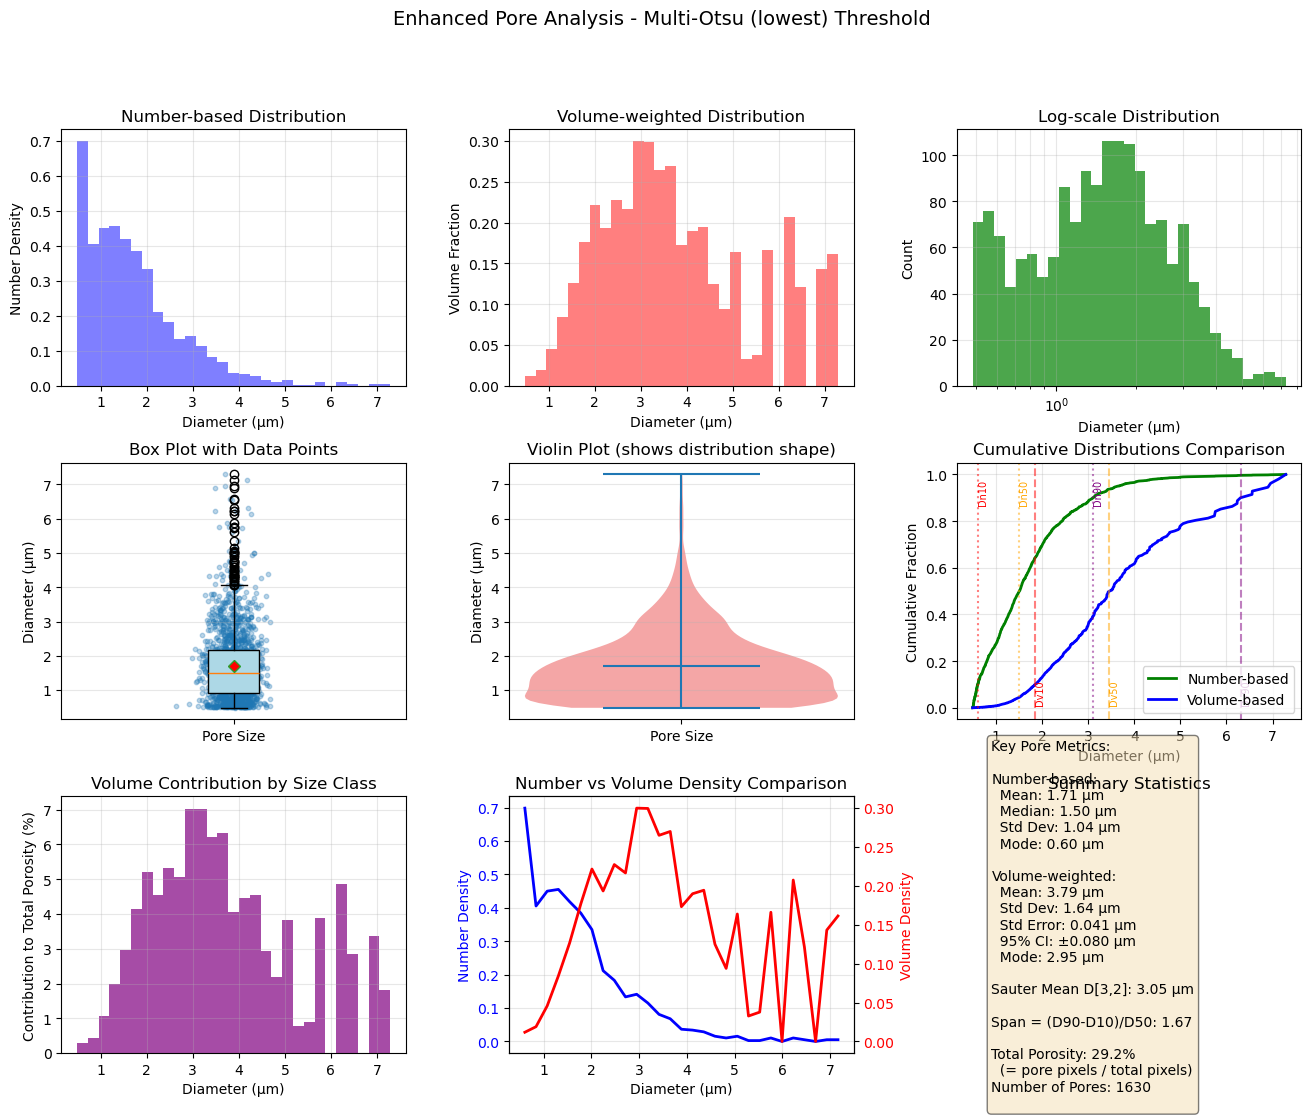

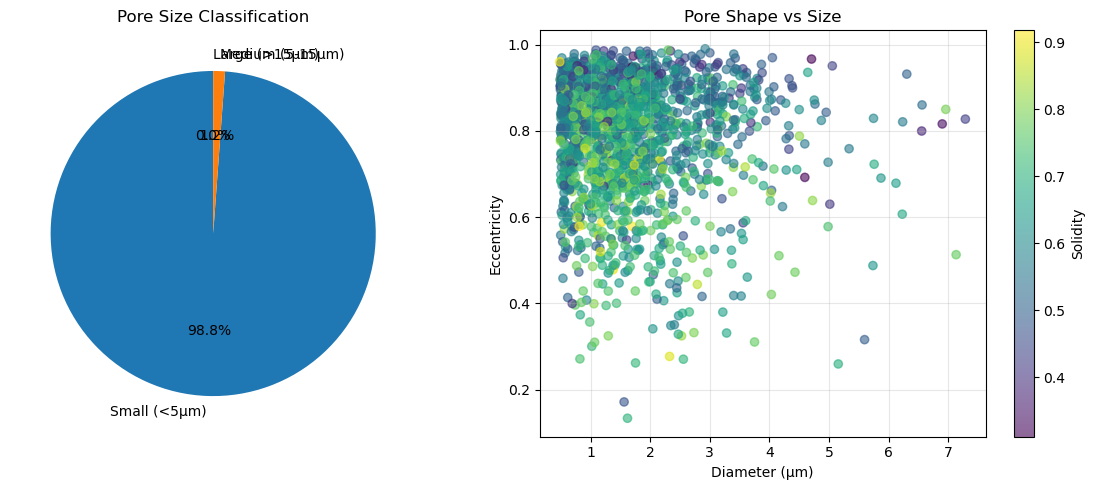


POROSITY CALCULATION

Total image pixels: 4,556,800
Pore pixels (True values): 1,328,687
Solid pixels (False values): 3,228,113

Porosity = Pore pixels / Total pixels
         = 1,328,687 / 4,556,800
         = 0.2916
         = 29.16%

Area-based porosity (sum of detected pore areas):
         = 1,328,687.0 / 4,556,800
         = 29.16%

Exportable Metrics Summary:
number_mean_diameter: 1.706
number_median_diameter: 1.497
number_std_dev: 1.040
volume_weighted_mean: 3.789
volume_weighted_std: 1.642
volume_weighted_sem: 0.041
volume_weighted_ci95: 0.080
sauter_mean_diameter: 3.050
D10: 0.598
D50: 1.497
D90: 3.104
span: 1.674
porosity_percent: 29.158
total_pores: 1630.000
mean_eccentricity: 0.786
mean_solidity: 0.626

UNDERSTANDING THE DISTRIBUTIONS

Cumulative Number Distribution:
- Shows what fraction of PORES are below a given size
- Dominated by small pores (there are many of them)
- Useful for: pore count statistics, nucleation studies

Cumulative Volume Distribution:
- Shows what 

In [185]:

# Add these visualization functions after your existing analysis

# Calculate volume-weighted distributions
# For 2D images, we use area as a proxy for volume
df['pore_volume'] = df['area_um2'] * df['equivalent_diameter_um']  # Approximation
df['volume_fraction'] = df['pore_volume'] / df['pore_volume'].sum()

# Create enhanced visualization figure
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Define bins consistently for all histograms
n_bins = 30
hist_bins = np.linspace(df['equivalent_diameter_um'].min(), 
                       df['equivalent_diameter_um'].max(), n_bins)
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2

# 1. Number-based vs Volume-weighted distributions
ax1 = fig.add_subplot(gs[0, 0])
# Number-based histogram
n_counts, _, _ = ax1.hist(df['equivalent_diameter_um'], bins=hist_bins, 
                          alpha=0.5, label='Number-based', 
                          color='blue', density=True)
ax1.set_xlabel('Diameter (μm)')
ax1.set_ylabel('Number Density')
ax1.set_title('Number-based Distribution')
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
# Volume-weighted histogram
weights = df['pore_volume'] / df['pore_volume'].sum()
v_counts, _, _ = ax2.hist(df['equivalent_diameter_um'], bins=hist_bins, 
                         weights=weights, alpha=0.5, 
                         label='Volume-weighted', color='red', density=True)
ax2.set_xlabel('Diameter (μm)')
ax2.set_ylabel('Volume Fraction')
ax2.set_title('Volume-weighted Distribution')
ax2.grid(True, alpha=0.3)

# 2. Log-scale distribution
ax3 = fig.add_subplot(gs[0, 2])
# Use log-spaced bins
log_bins = np.logspace(np.log10(df['equivalent_diameter_um'].min()), 
                      np.log10(df['equivalent_diameter_um'].max()), 30)
ax3.hist(df['equivalent_diameter_um'], bins=log_bins, alpha=0.7, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Diameter (μm)')
ax3.set_ylabel('Count')
ax3.set_title('Log-scale Distribution')
ax3.grid(True, alpha=0.3, which='both')

# 3. Box plot with individual points
ax4 = fig.add_subplot(gs[1, 0])
bp = ax4.boxplot(df['equivalent_diameter_um'], vert=True, patch_artist=True,
                 showmeans=True, meanprops=dict(marker='D', markerfacecolor='red'))
bp['boxes'][0].set_facecolor('lightblue')
# Add swarm plot overlay
y_jitter = np.random.normal(1, 0.04, size=len(df))
ax4.scatter(y_jitter, df['equivalent_diameter_um'], alpha=0.3, s=10)
ax4.set_ylabel('Diameter (μm)')
ax4.set_xticklabels(['Pore Size'])
ax4.set_title('Box Plot with Data Points')
ax4.grid(True, alpha=0.3, axis='y')

# 4. Violin plot
ax5 = fig.add_subplot(gs[1, 1])
parts = ax5.violinplot([df['equivalent_diameter_um']], positions=[1], 
                       showmeans=True, showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
ax5.set_ylabel('Diameter (μm)')
ax5.set_xticks([1])
ax5.set_xticklabels(['Pore Size'])
ax5.set_title('Violin Plot (shows distribution shape)')
ax5.grid(True, alpha=0.3, axis='y')

# 5. Cumulative distributions - both number and volume
ax6 = fig.add_subplot(gs[1, 2])
# Sort by diameter
df_sorted = df.sort_values('equivalent_diameter_um').reset_index(drop=True)

# Cumulative number distribution
cumulative_number = np.arange(1, len(df_sorted) + 1) / len(df_sorted)
ax6.plot(df_sorted['equivalent_diameter_um'], cumulative_number, 'g-', 
         linewidth=2, label='Number-based')

# Cumulative volume distribution
cumulative_volume = df_sorted['pore_volume'].cumsum() / df_sorted['pore_volume'].sum()
ax6.plot(df_sorted['equivalent_diameter_um'], cumulative_volume, 'b-', 
         linewidth=2, label='Volume-based')

ax6.set_xlabel('Diameter (μm)')
ax6.set_ylabel('Cumulative Fraction')
ax6.set_title('Cumulative Distributions Comparison')
ax6.grid(True, alpha=0.3)
ax6.legend()

# Add percentile markers for volume distribution
for percentile, color in [(10, 'red'), (50, 'orange'), (90, 'purple')]:
    # Volume-based percentile
    idx_vol = np.argmin(np.abs(cumulative_volume - percentile/100))
    d_vol = df_sorted['equivalent_diameter_um'].iloc[idx_vol]
    ax6.axvline(d_vol, color=color, linestyle='--', alpha=0.5)
    ax6.text(d_vol, 0.02, f'Dv{percentile}', rotation=90, fontsize=7, color=color)
    
    # Number-based percentile
    idx_num = int(len(df_sorted) * percentile / 100)
    d_num = df_sorted['equivalent_diameter_um'].iloc[idx_num]
    ax6.axvline(d_num, color=color, linestyle=':', alpha=0.5)
    ax6.text(d_num, 0.98, f'Dn{percentile}', rotation=90, fontsize=7, 
             color=color, va='top')

# 6. Pore size vs contribution to total porosity
ax7 = fig.add_subplot(gs[2, 0])
# Use the same bins for consistency
volume_contribution = []
for i in range(len(hist_bins)-1):
    mask = (df['equivalent_diameter_um'] >= hist_bins[i]) & (df['equivalent_diameter_um'] < hist_bins[i+1])
    volume_contribution.append(df[mask]['pore_volume'].sum() / df['pore_volume'].sum() * 100)

ax7.bar(hist_bin_centers, volume_contribution, width=hist_bins[1]-hist_bins[0], alpha=0.7, color='purple')
ax7.set_xlabel('Diameter (μm)')
ax7.set_ylabel('Contribution to Total Porosity (%)')
ax7.set_title('Volume Contribution by Size Class')
ax7.grid(True, alpha=0.3)

# 7. Number density vs Volume density comparison
ax8 = fig.add_subplot(gs[2, 1])
ax8_twin = ax8.twinx()
# Plot both on same graph
ax8.plot(hist_bin_centers, n_counts, 'b-', linewidth=2, label='Number density')
ax8.set_xlabel('Diameter (μm)')
ax8.set_ylabel('Number Density', color='b')
ax8.tick_params(axis='y', labelcolor='b')
ax8_twin.plot(hist_bin_centers, v_counts, 'r-', linewidth=2, label='Volume density')
ax8_twin.set_ylabel('Volume Density', color='r')
ax8_twin.tick_params(axis='y', labelcolor='r')
ax8.set_title('Number vs Volume Density Comparison')
ax8.grid(True, alpha=0.3)

# 8. Key metrics summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
# Calculate volume-weighted mean diameter
volume_weighted_mean = np.sum(df['equivalent_diameter_um'] * df['volume_fraction'])

# Calculate volume-weighted standard deviation
volume_weighted_variance = np.sum((df['equivalent_diameter_um'] - volume_weighted_mean)**2 * df['volume_fraction'])
volume_weighted_std = np.sqrt(volume_weighted_variance)

# Calculate standard error of the volume-weighted mean
volume_weighted_sem = volume_weighted_std / np.sqrt(len(df))

# Calculate 95% confidence interval
volume_weighted_ci95 = 1.96 * volume_weighted_sem

# Calculate Sauter mean diameter (D[3,2])
sauter_mean = np.sum(df['equivalent_diameter_um']**3) / np.sum(df['equivalent_diameter_um']**2)

summary_text = f"""Key Pore Metrics:

Number-based:
  Mean: {mean_diameter:.2f} μm
  Median: {median_diameter:.2f} μm
  Std Dev: {df['equivalent_diameter_um'].std():.2f} μm
  Mode: {hist_bin_centers[np.argmax(n_counts)]:.2f} μm

Volume-weighted:
  Mean: {volume_weighted_mean:.2f} μm
  Std Dev: {volume_weighted_std:.2f} μm
  Std Error: {volume_weighted_sem:.3f} μm
  95% CI: ±{volume_weighted_ci95:.3f} μm
  Mode: {hist_bin_centers[np.argmax(v_counts)]:.2f} μm
  
Sauter Mean D[3,2]: {sauter_mean:.2f} μm

Span = (D90-D10)/D50: {((df['equivalent_diameter_um'].quantile(0.9) - 
                          df['equivalent_diameter_um'].quantile(0.1)) / 
                          median_diameter):.2f}

Total Porosity: {porosity*100:.1f}%
  (= pore pixels / total pixels)
Number of Pores: {len(df)}
"""
ax9.text(0.1, 0.5, summary_text, transform=ax9.transAxes, 
         fontsize=10, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax9.set_title('Summary Statistics')

plt.suptitle(f'Enhanced Pore Analysis - {method_name} Threshold', fontsize=14)
plt.tight_layout()
plt.show()

# Additional analysis for hydrogel characterization
# Plot showing how pore characteristics might change between samples
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pore size classes distribution
size_classes = ['Small (<5μm)', 'Medium (5-15μm)', 'Large (>15μm)']
small = len(df[df['equivalent_diameter_um'] < 5])
medium = len(df[(df['equivalent_diameter_um'] >= 5) & (df['equivalent_diameter_um'] < 15)])
large = len(df[df['equivalent_diameter_um'] >= 15])
counts = [small, medium, large]

axes[0].pie(counts, labels=size_classes, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Pore Size Classification')

# Shape factor vs size plot (important for hydrogel structure)
axes[1].scatter(df['equivalent_diameter_um'], df['eccentricity'], 
                c=df['solidity'], cmap='viridis', alpha=0.6)
axes[1].set_xlabel('Diameter (μm)')
axes[1].set_ylabel('Eccentricity')
axes[1].set_title('Pore Shape vs Size')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1], label='Solidity')

plt.tight_layout()
plt.show()

# Porosity calculation explanation
print("\n" + "="*60)
print("POROSITY CALCULATION")
print("="*60)
print(f"\nTotal image pixels: {binary_cleaned.size:,}")
print(f"Pore pixels (True values): {np.sum(binary_cleaned):,}")
print(f"Solid pixels (False values): {np.sum(~binary_cleaned):,}")
print(f"\nPorosity = Pore pixels / Total pixels")
print(f"         = {np.sum(binary_cleaned):,} / {binary_cleaned.size:,}")
print(f"         = {porosity:.4f}")
print(f"         = {porosity*100:.2f}%")

# Alternative porosity calculations for comparison
area_based_porosity = df['area_pixels'].sum() / binary_cleaned.size
print(f"\nArea-based porosity (sum of detected pore areas):")
print(f"         = {df['area_pixels'].sum():,} / {binary_cleaned.size:,}")
print(f"         = {area_based_porosity*100:.2f}%")

if abs(porosity - area_based_porosity) > 0.01:
    print(f"\nNote: Difference of {abs(porosity - area_based_porosity)*100:.2f}% between methods")
    print("This could be due to:")
    print("- Small pores removed during cleaning")
    print("- Edge effects from segmentation")
    print("- Watershed separation creating boundaries")

# Export key metrics for comparison between samples
metrics_summary = {
    'number_mean_diameter': mean_diameter,
    'number_median_diameter': median_diameter,
    'number_std_dev': df['equivalent_diameter_um'].std(),
    'volume_weighted_mean': volume_weighted_mean,
    'volume_weighted_std': volume_weighted_std,
    'volume_weighted_sem': volume_weighted_sem,
    'volume_weighted_ci95': volume_weighted_ci95,
    'sauter_mean_diameter': sauter_mean,
    'D10': df['equivalent_diameter_um'].quantile(0.1),
    'D50': median_diameter,
    'D90': df['equivalent_diameter_um'].quantile(0.9),
    'span': (df['equivalent_diameter_um'].quantile(0.9) - df['equivalent_diameter_um'].quantile(0.1)) / median_diameter,
    'porosity_percent': porosity * 100,
    'total_pores': len(df),
    'mean_eccentricity': df['eccentricity'].mean(),
    'mean_solidity': df['solidity'].mean()
}

print("\nExportable Metrics Summary:")
for key, value in metrics_summary.items():
    print(f"{key}: {value:.3f}")

# Explain the difference between distributions
print("\n" + "="*60)
print("UNDERSTANDING THE DISTRIBUTIONS")
print("="*60)
print("\nCumulative Number Distribution:")
print("- Shows what fraction of PORES are below a given size")
print("- Dominated by small pores (there are many of them)")
print("- Useful for: pore count statistics, nucleation studies")

print("\nCumulative Volume Distribution:")
print("- Shows what fraction of PORE VOLUME is below a given size")
print("- Better represents contribution to transport properties")
print("- Useful for: permeability, diffusion, mechanical properties")

print("\nFor hydrogels:")
print("- If Dv50 >> Dn50: Few large pores dominate the structure")
print("- If Dv50 ≈ Dn50: More uniform pore size distribution")
# Calculate Dv50 for comparison
df_temp = df.sort_values('equivalent_diameter_um')
cum_vol_temp = df_temp['pore_volume'].cumsum() / df_temp['pore_volume'].sum()
dv50 = df_temp['equivalent_diameter_um'].iloc[np.argmin(np.abs(cum_vol_temp - 0.5))]
print(f"\nYour data: Dn50 = {median_diameter:.2f} μm")
print(f"          Dv50 = {dv50:.2f} μm")

# Save to CSV for comparison across samples
# df.to_csv('pore_analysis_data.csv', index=False)
# pd.DataFrame([metrics_summary]).to_csv('pore_metrics_summary.csv', index=False)
# print("\nData saved to 'pore_analysis_data.csv' and 'pore_metrics_summary.csv'")

In [186]:
# Explanation of calculations

# # Detailed explanation of cumulative distribution calculations
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Create example data to demonstrate the concept
# # Let's say we have 10 pores with these diameters (in μm)
# example_pores = pd.DataFrame({
#     'diameter': [2, 3, 5, 8, 10, 12, 15, 20, 25, 30],
#     'pore_id': range(1, 11)
# })

# # Calculate area for each pore (assuming circular pores)
# # Area = π * (diameter/2)²
# example_pores['area'] = np.pi * (example_pores['diameter'] / 2) ** 2

# # For 2D images, we approximate volume as area * diameter
# example_pores['volume'] = example_pores['area'] * example_pores['diameter']

# print("Example Pore Data:")
# print(example_pores)
# print("\n" + "="*60)

# # STEP 1: Sort the data by diameter (CRITICAL!)
# df_sorted = example_pores.sort_values('diameter').reset_index(drop=True)

# print("\nSTEP 1: Sort pores by diameter (smallest to largest)")
# print(df_sorted[['pore_id', 'diameter', 'area', 'volume']])

# # STEP 2: Calculate cumulative NUMBER distribution
# print("\n" + "="*60)
# print("CUMULATIVE NUMBER DISTRIBUTION")
# print("="*60)

# # For each pore, count how many pores are ≤ its diameter
# df_sorted['pores_at_or_below'] = range(1, len(df_sorted) + 1)
# df_sorted['cumulative_number_fraction'] = df_sorted['pores_at_or_below'] / len(df_sorted)

# print("\nFor each diameter, we count how many pores are ≤ that size:")
# print(df_sorted[['diameter', 'pores_at_or_below', 'cumulative_number_fraction']])

# print("\nExample: At diameter = 10 μm:")
# print(f"  - There are 5 pores with diameter ≤ 10 μm")
# print(f"  - Total number of pores = 10")
# print(f"  - Cumulative fraction = 5/10 = 0.5 (50%)")

# # STEP 3: Calculate cumulative VOLUME distribution
# print("\n" + "="*60)
# print("CUMULATIVE VOLUME DISTRIBUTION")
# print("="*60)

# # Calculate total volume
# total_volume = df_sorted['volume'].sum()
# print(f"\nTotal volume of all pores: {total_volume:.1f} μm³")

# # For each pore, sum the volume of all pores ≤ its diameter
# df_sorted['cumulative_volume'] = df_sorted['volume'].cumsum()
# df_sorted['cumulative_volume_fraction'] = df_sorted['cumulative_volume'] / total_volume

# print("\nFor each diameter, we sum the volume of all pores ≤ that size:")
# print(df_sorted[['diameter', 'volume', 'cumulative_volume', 'cumulative_volume_fraction']])

# print("\nExample: At diameter = 10 μm:")
# print(f"  - Volume of pores ≤ 10 μm = {df_sorted[df_sorted['diameter'] <= 10]['volume'].sum():.1f} μm³")
# print(f"  - Total volume = {total_volume:.1f} μm³")
# print(f"  - Cumulative fraction = {df_sorted[df_sorted['diameter'] <= 10]['volume'].sum() / total_volume:.3f}")

# # VISUALIZATION
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# # Plot 1: Bar chart showing individual pore volumes
# ax1 = axes[0, 0]
# bars = ax1.bar(df_sorted.index, df_sorted['volume'], color='skyblue', edgecolor='black')
# ax1.set_xlabel('Pore (sorted by size)')
# ax1.set_ylabel('Volume (μm³)')
# ax1.set_title('Individual Pore Volumes (sorted by diameter)')
# # Add diameter labels on bars
# for i, (d, v) in enumerate(zip(df_sorted['diameter'], df_sorted['volume'])):
#     ax1.text(i, v + 50, f'{d}μm', ha='center', fontsize=8)

# # Plot 2: Cumulative number distribution
# ax2 = axes[0, 1]
# ax2.plot(df_sorted['diameter'], df_sorted['cumulative_number_fraction'], 
#          'go-', linewidth=2, markersize=8, label='Number-based')
# ax2.set_xlabel('Diameter (μm)')
# ax2.set_ylabel('Cumulative Fraction')
# ax2.set_title('Cumulative Number Distribution')
# ax2.grid(True, alpha=0.3)
# ax2.set_ylim(0, 1.05)
# # Add annotations
# ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
# ax2.axvline(10, color='gray', linestyle='--', alpha=0.5)
# ax2.text(11, 0.48, 'Dn50 = 10 μm', fontsize=9)

# # Plot 3: Cumulative volume distribution
# ax3 = axes[1, 0]
# ax3.plot(df_sorted['diameter'], df_sorted['cumulative_volume_fraction'], 
#          'bo-', linewidth=2, markersize=8, label='Volume-based')
# ax3.set_xlabel('Diameter (μm)')
# ax3.set_ylabel('Cumulative Fraction')
# ax3.set_title('Cumulative Volume Distribution')
# ax3.grid(True, alpha=0.3)
# ax3.set_ylim(0, 1.05)
# # Find Dv50
# dv50_idx = np.argmin(np.abs(df_sorted['cumulative_volume_fraction'] - 0.5))
# dv50 = df_sorted['diameter'].iloc[dv50_idx]
# ax3.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
# ax3.axvline(dv50, color='gray', linestyle='--', alpha=0.5)
# ax3.text(dv50 + 1, 0.48, f'Dv50 ≈ {dv50:.0f} μm', fontsize=9)

# # Plot 4: Both distributions together
# ax4 = axes[1, 1]
# ax4.plot(df_sorted['diameter'], df_sorted['cumulative_number_fraction'], 
#          'go-', linewidth=2, markersize=6, label='Number-based')
# ax4.plot(df_sorted['diameter'], df_sorted['cumulative_volume_fraction'], 
#          'bo-', linewidth=2, markersize=6, label='Volume-based')
# ax4.set_xlabel('Diameter (μm)')
# ax4.set_ylabel('Cumulative Fraction')
# ax4.set_title('Comparison of Cumulative Distributions')
# ax4.grid(True, alpha=0.3)
# ax4.legend()
# ax4.set_ylim(0, 1.05)

# # Add shaded area to show difference
# ax4.fill_between(df_sorted['diameter'], 
#                  df_sorted['cumulative_number_fraction'],
#                  df_sorted['cumulative_volume_fraction'],
#                  alpha=0.2, color='gray')
# ax4.text(15, 0.3, 'Gap shows\nsize heterogeneity', fontsize=9, ha='center',
#          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# plt.tight_layout()
# plt.show()

# # KEY INSIGHTS
# print("\n" + "="*60)
# print("KEY INSIGHTS FROM THE DISTRIBUTIONS")
# print("="*60)

# print("\n1. Number-based distribution (green):")
# print("   - Answers: 'What fraction of pores are smaller than X?'")
# print("   - Each pore counts equally (1/10 = 10%)")
# print("   - Sensitive to numerous small pores")

# print("\n2. Volume-based distribution (blue):")
# print("   - Answers: 'What fraction of total pore volume is in pores smaller than X?'")
# print("   - Large pores contribute more (weighted by volume)")
# print("   - Better represents transport properties")

# print("\n3. The gap between curves indicates:")
# print("   - Wide gap = heterogeneous sizes (few large pores dominate)")
# print("   - Narrow gap = homogeneous sizes (uniform distribution)")

# # Practical calculation for real data
# print("\n" + "="*60)
# print("ALGORITHM FOR YOUR ACTUAL DATA")
# print("="*60)

# print("""
# # For your pore analysis data:
# # Assuming 'df' contains your pore measurements

# # 1. Sort by diameter
# df_sorted = df.sort_values('equivalent_diameter_um').reset_index(drop=True)

# # 2. Cumulative NUMBER distribution
# cumulative_number = np.arange(1, len(df_sorted) + 1) / len(df_sorted)
# # This creates: [1/n, 2/n, 3/n, ..., n/n] where n = number of pores

# # 3. Cumulative VOLUME distribution
# # First calculate pore volumes (for 2D, using area × diameter as proxy)
# df_sorted['pore_volume'] = df_sorted['area_um2'] * df_sorted['equivalent_diameter_um']
# # Then calculate cumulative sum and normalize
# cumulative_volume = df_sorted['pore_volume'].cumsum() / df_sorted['pore_volume'].sum()

# # 4. Plot against diameter
# plt.plot(df_sorted['equivalent_diameter_um'], cumulative_number, label='Number')
# plt.plot(df_sorted['equivalent_diameter_um'], cumulative_volume, label='Volume')
# """)

In [187]:
import os
import pandas as pd
import numpy as np

# Get the directory where the TIF file is located
tif_directory = os.path.dirname(tif_file_path)
# Get the folder name TWO levels above
parent_directory = os.path.dirname(tif_directory)  # One level up
grandparent_folder_name = os.path.basename(parent_directory)  # Get the name of folder two levels up

# Create the Excel filename - optionally include threshold method in filename
excel_filename = os.path.join(tif_directory, f'{grandparent_folder_name}_pore_analysis_{method_name.replace(" ", "_").replace("(", "").replace(")", "")}.xlsx')

# Calculate volume-weighted metrics (ensure these are calculated if not already)
if 'pore_volume' not in df.columns:
    df['pore_volume'] = df['area_um2'] * df['equivalent_diameter_um']
df['volume_fraction'] = df['pore_volume'] / df['pore_volume'].sum()

# Volume-weighted mean diameter
volume_weighted_mean = np.sum(df['equivalent_diameter_um'] * df['volume_fraction'])

# Volume-weighted standard deviation
volume_weighted_variance = np.sum((df['equivalent_diameter_um'] - volume_weighted_mean)**2 * df['volume_fraction'])
volume_weighted_std = np.sqrt(volume_weighted_variance)

# Calculate standard error of the volume-weighted mean
volume_weighted_sem = volume_weighted_std / np.sqrt(len(df))

# Calculate 95% confidence interval
volume_weighted_ci95 = 1.96 * volume_weighted_sem

# Sauter mean diameter (D[3,2])
sauter_mean = np.sum(df['equivalent_diameter_um']**3) / np.sum(df['equivalent_diameter_um']**2)

# Calculate volume-based percentiles
df_sorted = df.sort_values('equivalent_diameter_um')
cumulative_volume = df_sorted['pore_volume'].cumsum() / df_sorted['pore_volume'].sum()

# Function to find diameter at specific volume percentile
def get_volume_percentile(percentile):
    idx = np.argmin(np.abs(cumulative_volume - percentile/100))
    return df_sorted['equivalent_diameter_um'].iloc[idx]

# Create enhanced summary statistics
# FIXED: Removed '===' from headers to prevent Excel formula errors
summary_data = {
    'Metric': [
        'FILE INFORMATION',
        'Image Path',
        'Scale (μm/pixel)',
        'Threshold Method',
        'Threshold Value',
        '',
        'BASIC STATISTICS',
        'Total Pores Detected',
        'Porosity (%)',
        '',
        'NUMBER-BASED METRICS',
        'Mean Diameter (μm)',
        'Median Diameter (μm)',
        'Std Dev Diameter (μm)',
        'Min Diameter (μm)',
        'Max Diameter (μm)',
        '',
        'VOLUME-WEIGHTED METRICS',
        'Volume-Weighted Mean (μm)',
        'Volume-Weighted Std Dev (μm)',
        'Volume-Weighted Std Error (μm)',
        'Volume-Weighted 95% CI (μm)',
        'Sauter Mean D[3,2] (μm)',
        '',
        'DISTRIBUTION METRICS',
        'Span [(D90-D10)/D50]',
        'Uniformity Index [Dv50/Dn50]',
        '',
        'SHAPE METRICS',
        'Mean Eccentricity',
        'Mean Solidity',
        '',
        'SIZE CLASSIFICATION',
        'Small Pores (<5μm)',
        'Medium Pores (5-15μm)', 
        'Large Pores (>15μm)',
    ],
    'Value': [
        '',
        tif_file_path,
        f'{um_per_pixel:.6f}',
        method_name,
        f'{threshold:.0f}',
        '',
        '',
        len(df),
        f'{porosity*100:.2f}',
        '',
        '',
        f'{mean_diameter:.2f}',
        f'{median_diameter:.2f}',
        f'{std_diameter:.2f}',
        f'{df["equivalent_diameter_um"].min():.2f}',
        f'{df["equivalent_diameter_um"].max():.2f}',
        '',
        '',
        f'{volume_weighted_mean:.2f}',
        f'{volume_weighted_std:.2f}',
        f'{volume_weighted_sem:.3f}',
        f'±{volume_weighted_ci95:.3f}',
        f'{sauter_mean:.2f}',
        '',
        '',
        f'{((df["equivalent_diameter_um"].quantile(0.9) - df["equivalent_diameter_um"].quantile(0.1)) / median_diameter):.2f}',
        f'{get_volume_percentile(50) / median_diameter:.2f}',
        '',
        '',
        f'{df["eccentricity"].mean():.3f}',
        f'{df["solidity"].mean():.3f}',
        '',
        '',
        f'{len(df[df["equivalent_diameter_um"] < 5])} ({len(df[df["equivalent_diameter_um"] < 5])/len(df)*100:.1f}%)',
        f'{len(df[(df["equivalent_diameter_um"] >= 5) & (df["equivalent_diameter_um"] < 15)])} ({len(df[(df["equivalent_diameter_um"] >= 5) & (df["equivalent_diameter_um"] < 15)])/len(df)*100:.1f}%)',
        f'{len(df[df["equivalent_diameter_um"] >= 15])} ({len(df[df["equivalent_diameter_um"] >= 15])/len(df)*100:.1f}%)',
    ]
}
summary_df = pd.DataFrame(summary_data)

# Add NUMBER-BASED percentiles
# FIXED: Removed '===' from headers
summary_df = pd.concat([summary_df, pd.DataFrame({
    'Metric': ['', 'NUMBER-BASED PERCENTILES'],
    'Value': ['', '']
})], ignore_index=True)

percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    value = np.percentile(df['equivalent_diameter_um'], p)
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Metric': [f'Dn{p} - {p}th Percentile (μm)'],
        'Value': [f'{value:.2f}']
    })], ignore_index=True)

# Add VOLUME-BASED percentiles
# FIXED: Removed '===' from headers
summary_df = pd.concat([summary_df, pd.DataFrame({
    'Metric': ['', 'VOLUME-BASED PERCENTILES'],
    'Value': ['', '']
})], ignore_index=True)

for p in percentiles:
    value = get_volume_percentile(p)
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Metric': [f'Dv{p} - {p}th Volume Percentile (μm)'],
        'Value': [f'{value:.2f}']
    })], ignore_index=True)

# Create distribution data for plotting
# Prepare histogram data
n_bins = 30
hist_bins = np.linspace(df['equivalent_diameter_um'].min(), 
                       df['equivalent_diameter_um'].max(), n_bins)
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2

# Number-based histogram
n_counts, _ = np.histogram(df['equivalent_diameter_um'], bins=hist_bins)
n_density = n_counts / n_counts.sum()

# Volume-based histogram
volume_weights = df['pore_volume'] / df['pore_volume'].sum()
v_counts, _ = np.histogram(df['equivalent_diameter_um'], bins=hist_bins, weights=volume_weights)

# Create distribution DataFrame
distribution_df = pd.DataFrame({
    'Diameter_um': hist_bin_centers,
    'Number_Count': n_counts,
    'Number_Density': n_density,
    'Volume_Density': v_counts,
    'Diameter_Range_Start': hist_bins[:-1],
    'Diameter_Range_End': hist_bins[1:]
})

# Create cumulative distribution data
cumulative_df = pd.DataFrame({
    'Diameter_um': df_sorted['equivalent_diameter_um'],
    'Cumulative_Number': np.arange(1, len(df_sorted) + 1) / len(df_sorted),
    'Cumulative_Volume': cumulative_volume.values,
    'Individual_Volume': df_sorted['pore_volume'].values,
    'Individual_Area': df_sorted['area_um2'].values
})

# Save to Excel with multiple sheets
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # Sheet 1: Summary statistics (enhanced)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Sheet 2: Detailed pore data
    df.to_excel(writer, sheet_name='Pore Data', index=False)
    
    # Sheet 3: Distribution data for plotting
    distribution_df.to_excel(writer, sheet_name='Distribution Data', index=False)
    
    # Sheet 4: Cumulative distribution data
    cumulative_df.to_excel(writer, sheet_name='Cumulative Data', index=False)
    
    # Auto-adjust column widths for better readability
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        for column in worksheet.columns:
            max_length = 0
            column_letter = column[0].column_letter
            for cell in column:
                try:
                    cell_length = len(str(cell.value)) if cell.value else 0
                    if cell_length > max_length:
                        max_length = cell_length
                except:
                    pass
            adjusted_width = min(max_length + 2, 50)
            worksheet.column_dimensions[column_letter].width = adjusted_width
        
        # Format the summary sheet headers
        if sheet_name == 'Summary':
            from openpyxl.styles import Font, PatternFill
            # Bold and color the section headers
            # FIXED: Changed condition to not check for '===' since we removed them
            for row in worksheet.iter_rows():
                cell_value = str(row[0].value) if row[0].value else ''
                # Check if this is a section header (all caps and no parentheses)
                if cell_value and cell_value.isupper() and '(' not in cell_value and cell_value not in ['', ' ']:
                    row[0].font = Font(bold=True, color="FFFFFF")
                    row[0].fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")
                    row[1].fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")

# Create comparison metrics DataFrame for easy comparison across samples
comparison_metrics = pd.DataFrame({
    'Metric': [
        'Sample ID',
        'Threshold Method',
        'Threshold Value',
        'Porosity (%)',
        'Total Pores',
        'Number Mean Diameter (μm)',
        'Number Median Diameter (μm)',
        'Volume-Weighted Mean (μm)',
        'Volume-Weighted Std Dev (μm)',
        'Volume-Weighted Std Error (μm)',
        'Sauter Mean D[3,2] (μm)',
        'Dn10 (μm)',
        'Dn50 (μm)',
        'Dn90 (μm)',
        'Dv10 (μm)',
        'Dv50 (μm)',
        'Dv90 (μm)',
        'Span [(D90-D10)/D50]',
        'Uniformity Index [Dv50/Dn50]',
        'Mean Eccentricity',
        'Mean Solidity',
        'Small Pores (<5μm) Count',
        'Medium Pores (5-15μm) Count',
        'Large Pores (>15μm) Count'
    ],
    'Value': [
        grandparent_folder_name,
        method_name,
        threshold,
        porosity * 100,
        len(df),
        mean_diameter,
        median_diameter,
        volume_weighted_mean,
        volume_weighted_std,
        volume_weighted_sem,
        sauter_mean,
        df['equivalent_diameter_um'].quantile(0.1),
        median_diameter,
        df['equivalent_diameter_um'].quantile(0.9),
        get_volume_percentile(10),
        get_volume_percentile(50),
        get_volume_percentile(90),
        (df['equivalent_diameter_um'].quantile(0.9) - df['equivalent_diameter_um'].quantile(0.1)) / median_diameter,
        get_volume_percentile(50) / median_diameter,
        df['eccentricity'].mean(),
        df['solidity'].mean(),
        len(df[df['equivalent_diameter_um'] < 5]),
        len(df[(df['equivalent_diameter_um'] >= 5) & (df['equivalent_diameter_um'] < 15)]),
        len(df[df['equivalent_diameter_um'] >= 15])
    ]
})

# Debug print to show the folder structure
print(f"\nTIF file path: {tif_file_path}")
print(f"TIF directory: {tif_directory}")
print(f"Parent directory: {parent_directory}")
print(f"Folder name (two levels up): {grandparent_folder_name}")
print(f"\nExcel file saved as: {os.path.basename(excel_filename)}")
print(f"Full path: {excel_filename}")

print("\n" + "="*60)
print("EXCEL FILE CONTENTS (4 sheets):")
print("="*60)
print("Sheet 1 - Summary: Detailed statistics with all metrics organized by category")
print("Sheet 2 - Pore Data: Detailed measurements for each individual pore")
print("Sheet 3 - Distribution Data: Histogram bin data for recreating plots")
print("Sheet 4 - Cumulative Data: Data for cumulative distribution plots")
print("\nTip: Use the Summary sheet to quickly review all key metrics!")


TIF file path: C:\Users\Talaial Alina\OneDrive - UCB-O365\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\SEM\04JUL25\4% gelatin\1X PBS\28 cycles\11\35(x800).tif
TIF directory: C:\Users\Talaial Alina\OneDrive - UCB-O365\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\SEM\04JUL25\4% gelatin\1X PBS\28 cycles\11
Parent directory: C:\Users\Talaial Alina\OneDrive - UCB-O365\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\SEM\04JUL25\4% gelatin\1X PBS\28 cycles
Folder name (two levels up): 28 cycles

Excel file saved as: 28 cycles_pore_analysis_Multi-Otsu_lowest.xlsx
Full path: C:\Users\Talaial Alina\OneDrive - UCB-O365\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\SEM\04JUL25\4% gelatin\1X PBS\28 cycles\11\28 cycles_pore_analysis_Multi-Otsu_lowest.xlsx

EXCEL FILE CONTENTS (4 sheets):
Sheet 1 - Summary: Detailed statistics with all metrics organized by c